# A Scraper for Twitter User Data 

This project utilizes the googlesearch module with Tweepy to create a dataset of Twitter users, sourced from user-generated Twitter lists that match a given keyword. By using lists like so, we can bulk identify accounts that match a keyword without having to trawl through user attributes like bios. Tweepy allows access to a plethora of user/status/list data, so once lists and the users contained in the lists have been scraped, the breadth of data that can be collected is expansive. 

For demonstration purposes, the project here pulls in favorite and retweet actions and creates a measurement of engagement for each user collected. 

This script takes several minutes to run, depending on how intensive the Google search and Twitter API requests are. For Google, a conservative random sleep timer is used to best prevent timeouts. For Twitter, the API is instantiated using wait_on_rate_limit=True, meaning that if the API's wait limit is exceeded, the function will wait until the API is available again rather than throwing an error. 

The project requires access to Twitter's API, so you will need to a developer account with Twitter. Set up an account and project here for free: https://developer.twitter.com/en/apply-for-access.

The googlesearch module requires installation. Retrieve it here: https://github.com/MarioVilas/googlesearch. 

Notes:
- The results_to_obtain parameter for scrape_influencers_use_google() is currently set to 50. Increase the number to retrieve more lists and more users. If the number is increased significantly, set the sleep time between each URL to a longer period to prevent being locked out by Google. 
- The list_contains_string parameter is the keyword you will use to search for lists. 



In [4]:
# Module imports 
import tweepy
import time
import pandas as pd
import numpy as np
import json
import time
from random import randint, random
from googlesearch import search as gsearch
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pathlib
import os
from dotenv import load_dotenv


Authenticating to Twitter and creating the API connection.

Assign the keys for your Twitter developer account to the approriate variables. 

In [8]:
# name the file we want
env_file_name = 'lrhf97_twit_cred.env'
parent_dir = pathlib.Path.cwd().parent

env_path = parent_dir.joinpath(env_file_name)

load_dotenv(env_path)
test_cred = os.getenv("test_cred")
print(test_cred)

secretpassword


In [9]:
api_key = os.getenv("API_KEY")
secret_key = os.getenv("API_SECRET")
access_token = ''
secret_token = ''

def authenticate(api_key, secret_key, access_token, secret_token):

    auth = tweepy.OAuthHandler(api_key, secret_key)
    auth.set_access_token(access_token, secret_token)
    api = tweepy.API(auth, 
                     wait_on_rate_limit=True, 
                     wait_on_rate_limit_notify=True)
  
    return api


api = authenticate(api_key, secret_key, access_token, secret_token)

Some api calls will result in a rate limit error. While this script in it's current iteration does not require this now, the function below will handle those if needed for any Tweepy requests. 

In [10]:
def limit_handled(cursor):
    
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            time.sleep(2)
            continue

Parameter notes:
- list_contains_string - the list keyword to search for
- results to obtain - number of results to be recorded

Requesting a large number of results will likely cause Google to temporarily prevent access. 

In [16]:

def scrape_lists_with_google(keyword_string, results_to_obtain):

    list_urls = []

    urls_checked = 0
    urls_appended = 0
    
    # Perform the Google search, checking only the twitter.com domain
    for url in gsearch("site:twitter.com lists " + keyword_string,
                    #   start=urls_checked, 
                      num_results=results_to_obtain, 
                    #   pause=randint(3, 5)
                    ):
        
        # Take URLs that contain Twitter's '/lists' subdomain
        if '/lists/' in url:
            list_urls.append(url)
            urls_appended += 1
            urls_checked += 1

        # If Google is returning 5x as many non-list results as lists, break search
        if urls_checked / urls_appended > 5:
            break
        
        # If we reach our results # request limit, break the search
        elif urls_appended >= results_to_obtain:
            break
        
        # Sleep to prevent timeouts
        time.sleep(randint(3, 5))

    list_urls = [url[8:] for url in list_urls] # Removes leading https://

    return list_urls
  

list_urls = scrape_lists_with_google("influencers", 10)

In [17]:
list_urls


['twitter.com/trackmaven/lists/top-marketing-influencers',
 'twitter.com/up_slide/lists/m-a-influencers',
 'twitter.com/conversationage/lists/influencer-marketing',
 'twitter.com/workmommywork/lists/influencers',
 'twitter.com/soundhoundinc/lists/40-voice-influencers-2020-21649',
 'twitter.com/politicopro/lists/defense-influencers',
 'twitter.com/_bottlerocket/lists/wearables-influencers',
 'twitter.com/simplymeasured/lists/top-twitter-influencers',
 'twitter.com/uclg_org/lists/citieswewant']

Getting the individual users and associated attributes is made easy with Tweepy. Using the API created earlier, this function returns a dataframe of individual users and associated Twitter attributes. 

In [18]:
# Get user id, screen name, bio, follower count

def get_users_in_lists(list_urls):
  
    users_list = []
    bios_list = []
    desc_list = []
    follower_count_list = []
    
    for tw_list in list_urls:
    
        user = tw_list.split('/')[1]
        list_name = tw_list.split('/')[3]

        # Using Tweepy api, getting json of all users in list
        list_members_output = api.list_members(user, list_name)

        # Parsing json data and appending to appropriate lists instantiated above
        for user_id in list_members_output:
            users_list.append(user_id._json['id'])
            bios_list.append(user_id._json['screen_name'])
            desc_list.append(user_id._json['description'])
            follower_count_list.append(user_id._json['followers_count'])
            
    zipped_data = zip(users_list, bios_list, desc_list, follower_count_list)
    
    # Creates a pandas dataframe containing user attributes
    output_df = pd.DataFrame(list(zipped_data), columns=['user_id', 
                                                         'screen_name',
                                                         'bio',
                                                         'followers'])
    # Dropping duplicate users if they were in multiple lists
    output_df.drop_duplicates('user_id')
    
    output_df.set_index('user_id', inplace=True)
    
    return output_df
  

influencers_df = get_users_in_lists(list_urls)

In [19]:
influencers_df.sort_values(by='followers', ascending=False).head()

,screen_name,bio,followers
user_id,,,
44196397,elonmusk,,59986493
50393960,BillGates,Sharing things I'm learning about the world’s ...,55513789
21982720,ariannahuff,Mother. Sister. @HuffPost Founder. Founder & C...,2827371
36711022,DanRather,"Journalist, storyteller, lifelong reader. Texa...",2222471
25458378,AskAaronLee,Regional Manager @agorapulse. Trying to perfec...,1037336


Accounts which are protected will not be accessible for the majority of Tweepy user object functionality. These need to be removed. 

When the API connection was built at the start of the script, the wait_on_rate_limit and wait_on_rate_limit_notify parameters were set to true. While those will catch a wait limit error, notify us, and go again when ready, this function checks a lot of users very quickly and will hit the rate limit most of the time if left alone. A sleep timer for each user has been set as a random float up to 0.2 (representing sleep up to 0.2s). This will not prevent rate limit errors 100% of the time but strikes a balance between error prevention and run time. 

Run time for this function is as such maximized at 0.2 * n_users seconds.


In [20]:
def remove_protected_accounts(users_df):
    
    working_df = users_df.copy()
    protected_ids = []
    
    counter = 0
    for index, row in users_df.iterrows():
        user = api.get_user(id=index)._json
        if user['protected'] == True:
            protected_ids.append(index)
        counter += 1
        if counter % 100 == 0:
            print(str(counter) + '/' + str(len(working_df)) + ' IDs checked')
            print('Protected IDs found:', len(protected_ids), '\n')
        # Sleeping for up to 0.2s helps not to exceed Tweepy's rate limit.
        time.sleep(random() / 5)
    
    working_df.drop(labels=protected_ids, inplace=True)
    working_df.reset_index(inplace=True)
            
    return working_df
            

influencers_df = remove_protected_accounts(influencers_df)

100/155 IDs checked
Protected IDs found: 1 



Now protected accounts have been removed, engagements with users' tweets can be examined. We can't access actual impressions for tweets, but we can access some engagement actions (favorites, retweets) for tweets. By looking at engagement actions in relation to the number of followers a user has, we can see how much their audience is engaged with that user's content. 

While this particular notebook just overviews the scraping code, it's a helpful excercise to generate some additional data to demonstrate a use case. As we've been looking at influencers for the purposes of this script, we can get a fairly good measurement of how effective an influencer might be by looking at metrics like this. 



In [21]:
def calc_median_favorites(user_id):
    
    fav_list = []
    tweets = api.user_timeline(id=user_id, count=100)
    
    for tweet in tweets:
        # Remove retweets
        if tweet._json['text'].startswith('RT'):
            continue
        # Remove replies
        elif tweet._json['text'].startswith('@'):
            continue
        else:
            fav_list.append(tweet._json['favorite_count'])
    
    time.sleep(random() / 5)
    
    return np.median(fav_list)  


influencers_df['median_favs'] = influencers_df['user_id'].apply(lambda x: calc_median_favorites(x))

/home/lrhf97/anaconda3/envs/twit_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [22]:
def calc_median_retweets(user_id):
    
    rt_list = []
    tweets = api.user_timeline(id=user_id, count=100)
    
    for tweet in tweets:
        if tweet._json['text'].startswith('RT'):
            continue
        else:
            rt_list.append(tweet._json['retweet_count'])
    
    time.sleep(random() / 5)
    
    return np.median(rt_list)  


influencers_df['median_rts'] = influencers_df['user_id'].apply(lambda x: calc_median_retweets(x))

In [23]:
influencers_df[5:10]

,user_id,screen_name,bio,followers,median_favs,median_rts
5,292418292,FeldmanCreative,Digital marketing super freak \n#content marke...,49570,1.0,0.0
6,223666748,j1berger,Author THE CATALYST https://t.co/N92ZWuooZk CO...,31689,11.0,0.0
7,208271692,SociallySorted,Founder of Socially Sorted | Visual Social Med...,46830,1.0,0.0
8,142012799,Allen,Author of The Creative Curve 📚 Angel invest in...,15707,4.0,0.0
9,92096544,TheSalesLion,Acclaimed International Keynote Speaker. Autho...,23592,9.5,0.0


We've likely got a notification above for a RuntimeWarning. This is numpy trying to take the median of of an empty array, that is, accounts that have never tweeted. Those accounts are visbile in the data as they have nan values under median_favs and/or median_rts. We can check to see if any exist using a heatmap for null values. 

<AxesSubplot:>

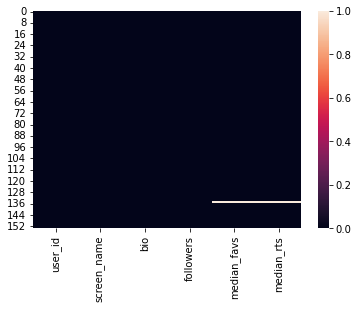

In [24]:
sns.heatmap(influencers_df.isnull())

Since there are nulls, we'll remove those and be left with a clean dataset. Creating a heatmap again confirms this. 

<AxesSubplot:>

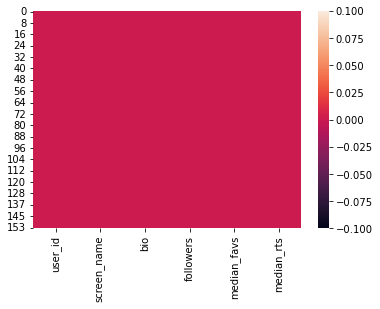

In [25]:
influencers_df = influencers_df.loc[~influencers_df['median_favs'].isnull()]
sns.heatmap(influencers_df.isnull())

Now, to create some kind of engagement metric. 

Firstly, we should remove accounts that are not often interacted with, that is, where media favs == 0. Also since the way we're crowdsourcing this data is highly subjective, we should set a low cutoff for follower count. We'll make this 1000. 

Secondle, we need a solid proxy for engagement. We can use the mean of median_favs / # of followers and median_rts / # of followers, so we'll create that column now. The resulting array features mostly small numbers which are difficult to compare so we'll also standardize the column. 

In [26]:
def remove_low_engagement_accounts(df):
    
    working_df = df.copy()
    
    working_df = working_df.loc[(working_df['median_favs'] > 0) &
                                (working_df['followers'] >= 1000)]
    
    return working_df

influencers_df = remove_low_engagement_accounts(influencers_df)

In [28]:
def create_engagement_metric(df):
      
    working_df = df.copy()
    
    from sklearn.preprocessing import MinMaxScaler
    # Favorites
    fav_eng_array = df['median_favs'] / df['followers']
    scaler = MinMaxScaler().fit(fav_eng_array.values.reshape(-1, 1))
    scaled_favs = scaler.transform(fav_eng_array.values.reshape(-1, 1))
    
    # Retweets
    rt_eng_array = df['median_favs'] / df['followers']
    scaler = MinMaxScaler().fit(rt_eng_array.values.reshape(-1, 1))
    scaled_rts = scaler.transform(rt_eng_array.values.reshape(-1, 1))
    
    mean_eng = (scaled_favs + scaled_rts) / 2
    working_df['engagement'] = mean_eng
    
    return working_df
                                                

influencers_df = create_engagement_metric(influencers_df)

In [29]:
influencers_df.sort_values('engagement', ascending=False).head()

,user_id,screen_name,bio,followers,median_favs,median_rts,engagement
52,1059273780,AdamMGrant,Organizational psychologist @Wharton. #1 NYT b...,476743,3581.5,855.5,1.000000
102,419027846,WilliamHartung,Expert on national security/foreign policy at ...,3107,22.5,12.0,0.963942
67,20749410,finkd,,482639,1729.5,324.0,0.476679
70,952943103803101184,PretzelVoice,#VoiceFirst #AI * Founder at https://t.co/3UY1...,2633,9.0,0.0,0.454666
64,36711022,DanRather,"Journalist, storyteller, lifelong reader. Texa...",2222471,6853.5,1106.5,0.410122


So that's a start on scraping some "crowdsourced" data from Twitter. From here it would be easy enough to generate some business level insights, but we'll save that for another notebook to keep this exercise concise. 

The next step for this project is to translate this "notebook" code into a production friendly .py file. 